#### This jupyter notebook looks at the debt to gdp ratio from 2000 to 2021
##### Sources:

- https://fiscaldata.treasury.gov/datasets/debt-to-the-penny/debt-to-the-penny
- https://fred.stlouisfed.org/series/GDPC1



In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import date2num
from datetime import datetime

/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


#### Data Shaping

In [2]:
url = ('https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/debt_to_penny?fields=record_date,debt_held_public_amt,intragov_hold_amt,tot_pub_debt_out_amt,record_fiscal_quarter&page[number]=1&page[size]=6000&filter=record_date:gt:2000-01-01')
response = requests.get(url)
x = response.json()
debt = pd.json_normalize(x, 'data')

out = []
for index, row in debt.iterrows():
    year = row.record_date.split('-')[0]
    month = row.record_date.split('-')[1]
    data = year+'-'+month+'-01'
    out.append(data)
debt2 = debt.assign(month_debt = pd.DataFrame(out))

gdp = pd.read_csv('GDPC1.csv')
out = []
for index, row in gdp.iterrows():
    year = row.DATE.split('-')[0]
    month = row.DATE.split('-')[1]
    data = year+'-'+month+'-01'
    out.append(data)
gdp2 = gdp.assign(month_gdp = pd.DataFrame(out))

df = pd.merge(debt2, gdp2, left_on = 'month_debt', right_on = 'month_gdp', how = 'left')

df2 = df[(df.debt_held_public_amt!='null')&(df.GDPC1.notnull())].drop_duplicates('month_gdp',keep="first").reset_index(drop=True)
df2.GDPC1 = df2.GDPC1 * 1000000000
df2.debt_held_public_amt = df2.debt_held_public_amt.astype('float64')
df3 = df2.assign(debt_gdp = df2.debt_held_public_amt / df2.GDPC1).rename(columns={'month_gdp':'month'})
df3.month = df3.month.astype('datetime64')

#### Debt to GDP Ratio Visualized

([<matplotlib.axis.YTick at 0x7fe25d8716d0>,
 <a list of 11 Text major ticklabel objects>)

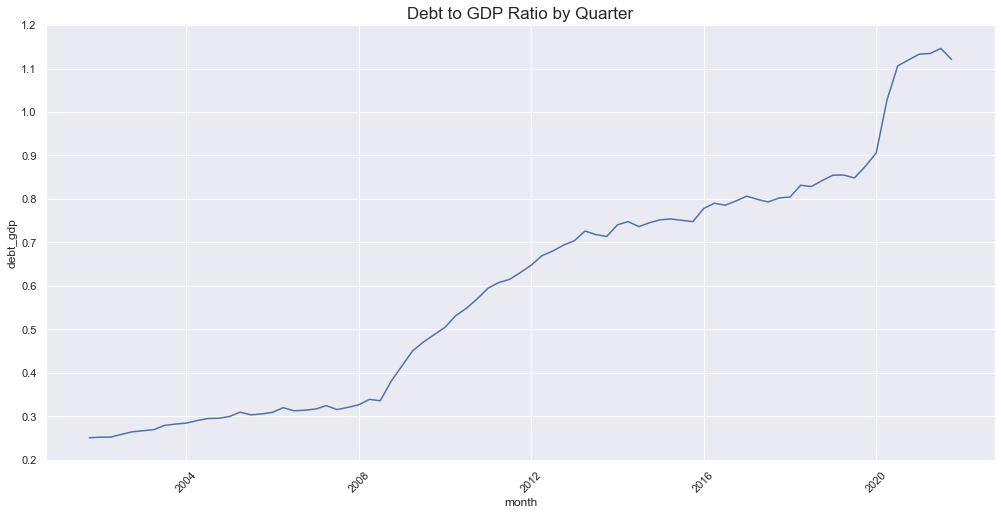

In [3]:
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(17,8)})
sns.lineplot(data=df3, x="month", y="debt_gdp")
plt.tick_params(axis='x', labelrotation = 45)
plt.title('Debt to GDP Ratio by Quarter',size = 17)
plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2])

#### Debt and GDP Visualized

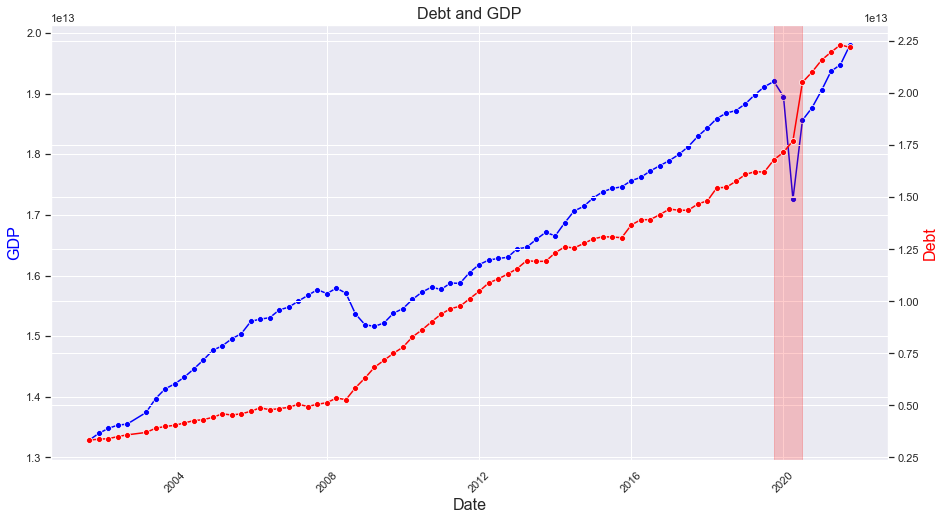

In [4]:
fig, ax1 = plt.subplots(figsize=(15,8))
ax1.set_title('Debt and GDP', fontsize=16)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('GDP', fontsize=16, color = 'blue')
ax1 = sns.lineplot(x ='month' ,y = 'GDPC1',data = df3, marker='o', color = 'blue', sort = False)
ax1.tick_params(axis='x', labelrotation = 45)
ax2 = ax1.twinx()
ax2.set_ylabel('Debt', fontsize=16, color = 'red')
ax2 = sns.lineplot(x= 'month', y='debt_held_public_amt', data = df3, marker = 'o', color = 'red', sort=False)
ax2.tick_params(axis='x', labelrotation = 45)
ax2.axvspan(date2num(datetime(2019,10,1)), date2num(datetime(2020,7,1)), color='red',alpha=0.2)
plt.show()